# **Nama : 2209106021**
# **NIM  : Bimasakti Cahyo Utomo**

Dataset : [Wonders of The World (Kaggle)](https://www.kaggle.com/datasets/balabaskar/wonders-of-the-world-image-classification)

Dataset ini berisi gambar Keajaiban dunia (Wonders of The World) yang berjumlah
12 kelas


### Untuk Google Colab

In [1]:
!pip install opendatasets
!pip install opendatasets
!pip install split-folders
import opendatasets as od
od.download("https://www.kaggle.com/datasets/balabaskar/wonders-of-the-world-image-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bimasakticahyoutomo
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/balabaskar/wonders-of-the-world-image-classification


## **Import Library**

In [8]:
import os
import random
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import splitfolders
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

## **Memindah Folder**

In [10]:
src = "/content/wonders-of-the-world-image-classification/Wonders of World/Wonders of World"
dst = "/content/Wonders of World"

if not os.path.exists(dst):
    shutil.move(src, dst)
    print("Folder berhasil dipindahkan.")
else:
    print("Folder sudah ada, tidak dipindahkan.")

Folder sudah ada, tidak dipindahkan.


## **Membagi folder Menggunakan Splitfolders**
Folder dibagi menjadi train , test dan val dengan rasio 8 : 1 : 1 menggunakan splitfolder ke dalam folder bernama dataset_final

In [11]:
splitfolders.ratio("Wonders of World",
                    output="dataset_final",
                    seed=1337,
                    ratio=(.8,.1,.1))

Copying files: 3846 files [00:01, 3177.66 files/s]


## **Augmentasi**

Augmentasi digunakan untuk mereplikasi keadaan di dunia nyata serta mengurangi overfitting pada model.

* `rescale=1/255`
  Menormalisasi nilai piksel dari 0–255 menjadi 0–1 agar sesuai dengan input model.
* `rotation_range=20`
  Mengacak rotasi gambar hingga ±20 derajat.
* `brightness_range=[0.9, 1.1]`
  Mengubah kecerahan gambar dalam rentang 90% hingga 110%.
* `vertical_flip=True`
  Membalik gambar secara vertikal (atas-bawah) secara acak.
* `horizontal_flip=True`
  Membalik gambar secara horizontal (kiri-kanan) secara acak.
* `zoom_range=0.2`
  Memperbesar atau memperkecil gambar hingga ±20%.
* `width_shift_range=0.2`
  Menggeser gambar secara horizontal hingga ±20% dari lebar gambar.
* `height_shift_range=0.2`
  Menggeser gambar secara vertikal hingga ±20% dari tinggi gambar.


In [12]:
img_height = 128
img_width = 128
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    brightness_range=[0.9, 1.1],
    vertical_flip=True,
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
  )


## **Data Generator**
Dengan konfigurasi ini, data dari folder bisa langsung diberi ke CNN untuk pelatihan, validasi, dan pengujian tanpa perlu pemrosesan manual tambahan

In [13]:
train_generator = train_datagen.flow_from_directory(
    'dataset_final/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = train_datagen.flow_from_directory(
    'dataset_final/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = train_datagen.flow_from_directory(
    'dataset_final/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3072 images belonging to 12 classes.
Found 381 images belonging to 12 classes.
Found 393 images belonging to 12 classes.


## **Membuat Arsitektur CNN**
 Model CNN ini dibangun menggunakan Sequential dengan layer CNN :
* `Conv2D`
Mendeteksi fitur seperti tepi, sudut, tekstur, dll. dari gambar.
* `MaxPooling2D`
Mengurangi ukuran fitur map (dimensi), agar model lebih ringan dan mencegah overfitting.
* `Flatten`
Mengubah data 2D hasil konvolusi & pooling menjadi vektor 1D agar bisa masuk ke dense layer.
* `Dense`
Menghasilkan probabilitas untuk masing-masing dari 12 kelas.
* `Softmax`
Mengubah output menjadi distribusi probabilitas total = 1.
* `Dropout`
Secara acak menonaktifkan (drop) sejumlah unit neuron (beserta koneksi-koneksinya) dalam jaringan.

In [24]:
model = Sequential([
    # 1. feature extraction layer
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # 2. fully connected layer,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(12, activation='softmax'),
])


## **Compile Model**
`Optimizer`: `adam` — kombinasi terbaik antara kecepatan dan akurasi.

`Loss function`: `categorical_crossentropy` — digunakan karena kita melakukan klasifikasi multi-kelas.

`Metrics`: `accuracy` untuk melihat akurasi pelatihan dan validasi.

In [25]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

## **Callback Early dan Stopping Training Model**
Callback early stopping digunakan untukk Menghentikan pelatihan secara otomatis jika val_accuracy (akurasi validasi) tidak meningkat setelah sejumlah epoch tertentu.

* **`monitor='val_accuracy'`**: Memantau metrik `val_accuracy`.
* **`patience=10`**: Jika dalam 10 epoch berturut-turut tidak ada peningkatan, pelatihan dihentikan.
* **`train_generator`**: Generator data untuk pelatihan (menghasilkan batch gambar dan label).
* **`epochs=100`**: Model dilatih maksimal selama 100 epoch.
* **`validation_data=val_generator`**: Data validasi yang digunakan untuk mengevaluasi model setiap epoch.
* **`verbose=1`**: Menampilkan progress bar training.
* **`callbacks=[monitor_callback]`**: Menambahkan callback `EarlyStopping` agar pelatihan bisa berhenti lebih awal jika model tidak ada kemajuan.

In [26]:
monitor_callback = EarlyStopping(monitor='val_accuracy', patience=10)

history = model.fit(train_generator, epochs=45,
            validation_data=val_generator,
            verbose=1,
            callbacks = [monitor_callback])

Epoch 1/45
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 299ms/step - accuracy: 0.1543 - loss: 2.3939 - val_accuracy: 0.1864 - val_loss: 2.2648
Epoch 2/45
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - accuracy: 0.2244 - loss: 2.1785 - val_accuracy: 0.2572 - val_loss: 2.1605
Epoch 3/45
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 292ms/step - accuracy: 0.2844 - loss: 2.0194 - val_accuracy: 0.3465 - val_loss: 1.9433
Epoch 4/45
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 290ms/step - accuracy: 0.3710 - loss: 1.8444 - val_accuracy: 0.3412 - val_loss: 1.9216
Epoch 5/45
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 285ms/step - accuracy: 0.3902 - loss: 1.7892 - val_accuracy: 0.4173 - val_loss: 1.7889
Epoch 6/45
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 287ms/step - accuracy: 0.4298 - loss: 1.6622 - val_accuracy: 0.4541 - val_loss: 1.6350
Epoch 7/45
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 293ms/step - accuracy: 0.4781 - loss: 1.5817 - val_accuracy: 0.4934 - val_loss: 1.6270
Epoch 8/45
96/96 ━━━━━━━━━━━━━━━━━━━━ 27s 286ms/step - accuracy: 0.4848 - loss: 1.5018 - val_accu

## **Visualisasi Pelatihan**

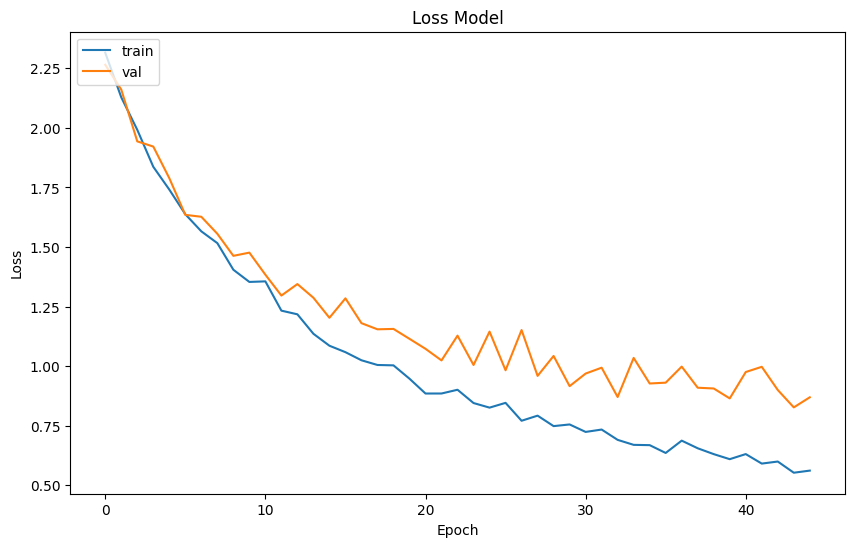

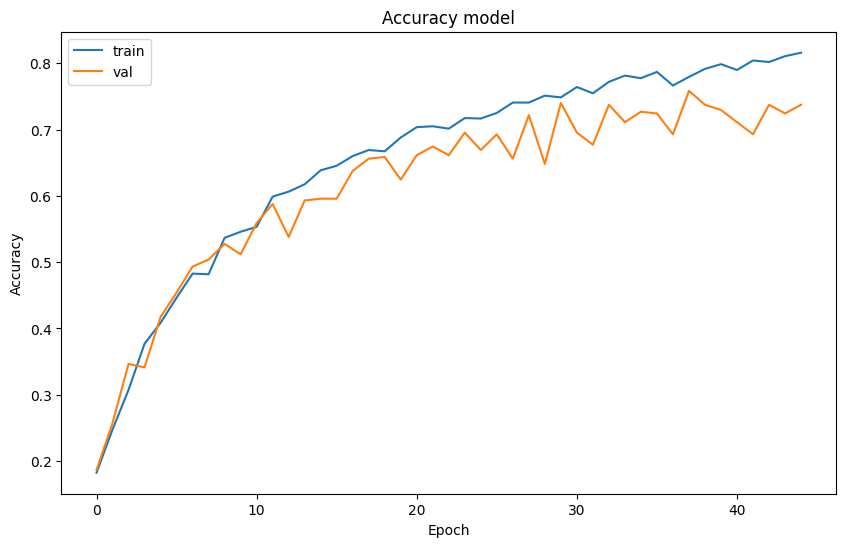

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Evaluasi Akhir**

In [28]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test Accuracy:', test_acc)
print('Test Loss: ', test_loss)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - accuracy: 0.7010 - loss: 0.8995
Test Accuracy: 0.7404580116271973
Test Loss:  0.8286979794502258


## **Test Model**

Digunakan untuk memvisualisasikan performa model dengan menampilkan prediksi dan label asli. Jika prediksi benar maka berwarna hijau jika salah maka berwarna merah.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


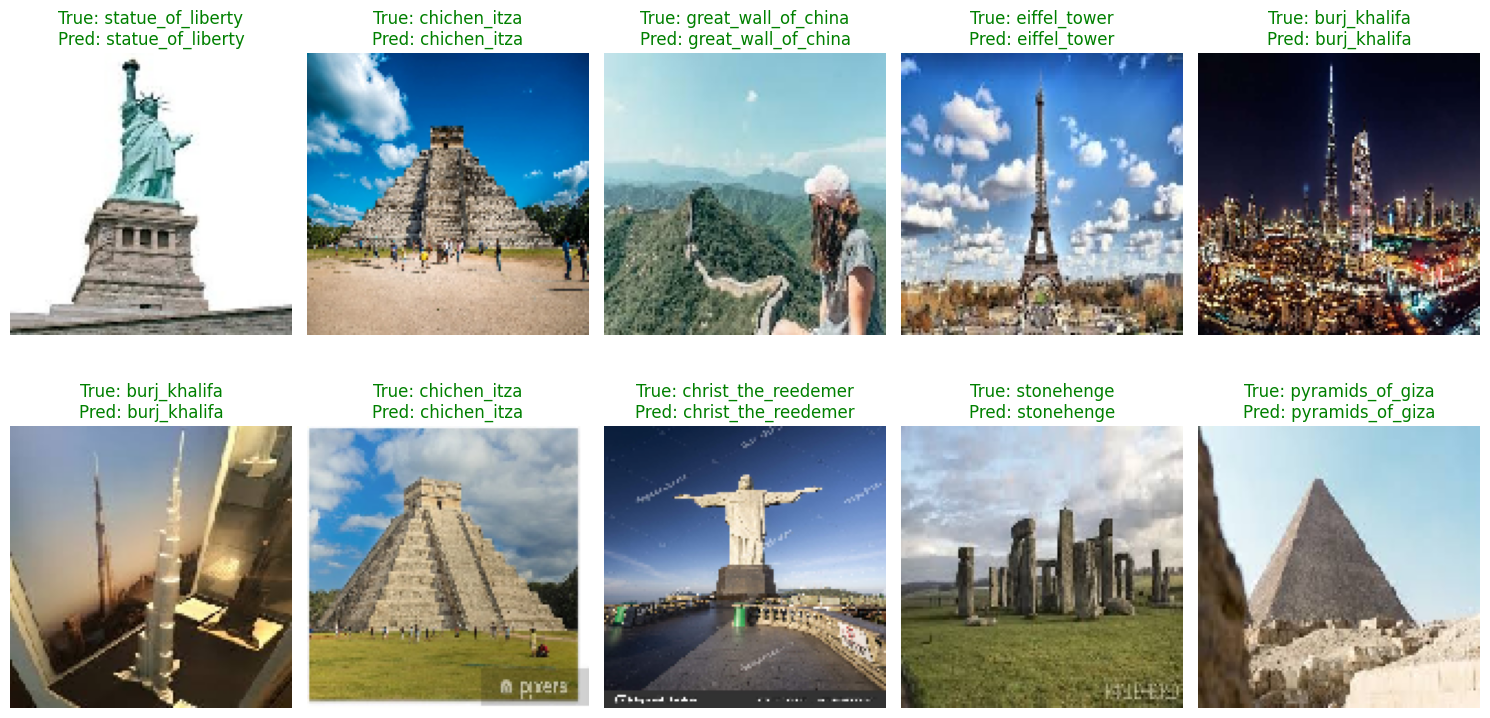

In [40]:
def visualize_sample_predictions_cnn(model, folder_path, class_indices, img_size=(128, 128), num_samples=10):
    image_paths = []
    labels = []

    # Invert class_indices to get index -> class_name
    idx_to_class = {v: k for k, v in class_indices.items()}

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(img_path)
                labels.append(class_name)

    if num_samples > len(image_paths):
        num_samples = len(image_paths)
        print(f"Hanya {num_samples} gambar yang tersedia, menyesuaikan jumlah sampel.")

    indices = np.random.choice(len(image_paths), num_samples, replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        true_label = labels[idx]

        try:
            image = load_img(img_path, target_size=img_size)
            image_array = img_to_array(image) / 255.0
            image_batch = np.expand_dims(image_array, axis=0)

            pred_probs = model.predict(image_batch)
            pred_idx = np.argmax(pred_probs)
            pred_label = idx_to_class[pred_idx]

            plt.subplot(2, 5, i + 1)
            plt.imshow(image)
            plt.title(f"True: {true_label}\nPred: {pred_label}",
                      color='green' if true_label == pred_label else 'red')
            plt.axis('off')
        except Exception as e:
            print(f"Gagal memproses gambar: {img_path}\nError: {e}")

    plt.tight_layout()
    plt.show()

class_indices = train_generator.class_indices
visualize_sample_predictions_cnn(model, "dataset_final/test", class_indices, img_size=(128, 128), num_samples=10)